In [ ]:
from lnm import LNMDataset, PandasDatasetLoader
from lnm.analysis import network_sensitivity_permutation_analysis
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker

# Load the participant data
participant_data = pd.read_csv('example_data/aphasia_recovery_participants.csv')

# Filter for Broca and NoAphasia
filtered_df = participant_data[participant_data['wab_type'].isin(['Broca', 'NoAphasia'])].copy()

# Create a case-control column (1 for Broca, 0 for NoAphasia)
filtered_df['case_control'] = (filtered_df['wab_type'] == 'Broca').astype(int)
filtered_df.reset_index(drop=True, inplace=True)

# Define paths
output_dir = '/Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb21/feb_22'

# Load data using PandasDatasetLoader
loader = PandasDatasetLoader(
    df=filtered_df,
    subject_col='subject',
    network_col='t',
    mask_col='roi_2mm',
)
data = loader.load()

# Create the dataset
ds = LNMDataset(
    networks=data.networks,
    mask_img=data.mask_img,
    roi_masks=data.roi_masks,
    output_prefix=output_dir,
    control_roi_volume=True,
    control_roi_centrality=True, 
    add_intercept=True,
    design_matrix=filtered_df['case_control'].values,
    contrast_matrix=np.array([1, 0, 0, 0]),  # Test case-control contrast
    cases_control_labels=filtered_df['case_control'].values,
    n_permutations=100, 
    save_permutations=False,
    return_permutations=True
)
ds.load_data()

# # Run GLM analysis
# # sensitivity_results = ds.network_sensitivity_analysis()
results = ds.network_glm_analysis()
# results = ds.network_conjunction_analysis()
# results = ds.network_sensitivity_permutation_analysis()


/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.
  warnings.warn("Mask provided but data is not NIfTI; Interesting choice. Behavior

Saved permuted indices for c1 to /Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb22/feb_22_permuted_indices_c1.csv


Running sensitivity permutations: 100%|██████████| 50/50 [00:04<00:00, 12.22it/s]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.


--- Processing Contrast c1 (1/1) ---


/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.
  warnings.warn("Mask provided but data is not NIfTI; Interesting choice. Behavior

Saved permuted indices for c1 to /Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb22/feb_22_permuted_indices_c1.csv


Running sensitivity permutations: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.


--- Processing Contrast c1 (1/1) ---


/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.
  warnings.warn("Mask provided but data is not NIfTI; Interesting choice. Behavior

Saved permuted indices for c1 to /Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb22/feb_22_permuted_indices_c1.csv


Running sensitivity permutations: 100%|██████████| 50/50 [00:04<00:00, 11.92it/s]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.


--- Processing Contrast c1 (1/1) ---


/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jiturner/miniforge3/envs/analysis_env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/jiturner/Repositories/prism/prism/datasets/dataset.py:230: UserWarning: Mask provided but data is not NIfTI; Interesting choice. Behavior might be unexpected.
  warnings.warn("Mask provided but data is not NIfTI; Interesting choice. Behavior

Saved permuted indices for c1 to /Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb22/feb_22_permuted_indices_c1.csv


Running sensitivity permutations: 100%|██████████| 50/50 [00:04<00:00, 11.86it/s]


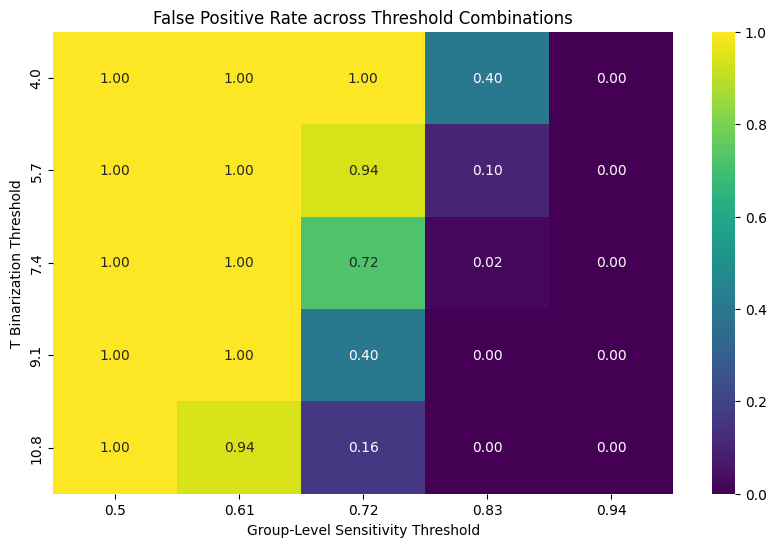

In [1]:
from lnm import LNMDataset, PandasDatasetLoader
from lnm.analysis import network_sensitivity_permutation_analysis
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
import matplotlib.pyplot as plt
import seaborn as sns

t_binarize_threshold_range = np.arange(4, 12.5, (12.5 - 4) / 5)
group_level_threshold_range = np.arange(0.50, 1.05, (1.05 - 0.50) / 5)
initial_random_state = 42
n_permutations_per_iteration = 50

# Load the participant data
filtered_df = pd.read_csv('/Users/jiturner/Repositories/lnm-toolkit/example_data/amnesia_ferguson2019_vs_atlas2.csv')
filtered_df['case_control'] = filtered_df['amnesia']

# Define paths
output_dir = '/Users/jiturner/Repositories/lnm-toolkit/joseph_output/feb22/feb_22'

# Load data using PandasDatasetLoader
loader = PandasDatasetLoader(
    df=filtered_df,
    subject_col='subject',
    network_col='t',
    mask_col='roi_2mm',
)
data = loader.load()

# Create the dataset
ds = LNMDataset(
    networks=data.networks,
    mask_img=data.mask_img,
    roi_masks=data.roi_masks,
    output_prefix=output_dir,
    control_roi_volume=True,
    control_roi_centrality=True, 
    add_intercept=True,
    design_matrix=filtered_df['amnesia'].values,
    contrast_matrix=np.array([1, 0, 0, 0]),  # Test case-control contrast
    cases_control_labels=filtered_df['case_control'].values,
    n_permutations=n_permutations_per_iteration,
    save_permutations=False,
    return_permutations=True
)
ds.load_data()

# Create a list of tuples of every threshold combination, and call it sensitivity_threshold_combinations
sensitivity_threshold_combinations = [(t, g) for t in t_binarize_threshold_range for g in group_level_threshold_range]
sensitivity_results_matrix = np.zeros((len(t_binarize_threshold_range), len(group_level_threshold_range)))
for iteration_idx in range(len(sensitivity_threshold_combinations)):
    # if iteration_idx > 0:
    #     break # This is to make testing more manageable.
    sensitivity_threshold, group_sensitivity_threshold = sensitivity_threshold_combinations[iteration_idx]
    ds.random_state = initial_random_state + iteration_idx
    ds.sensitivity_threshold = sensitivity_threshold
    ds.group_sensitivity_threshold = group_sensitivity_threshold
    specificity_spec_results = ds.network_glm_analysis()
    sensitivity_perm_results = ds.network_sensitivity_permutation_analysis()
    assert np.all(specificity_spec_results.permuted_indices == sensitivity_perm_results.permuted_indices)
    assert specificity_spec_results.permuted_stats.shape == sensitivity_perm_results.permuted_sensitivity_maps.shape
    spec_perm_data = specificity_spec_results.permuted_stats
    sense_perm_data = sensitivity_perm_results.permuted_sensitivity_maps
    sens_perm_data_binarized = np.where(np.abs(sense_perm_data) >= group_sensitivity_threshold*100, 1, 0)
    fpr = np.mean(np.count_nonzero(sens_perm_data_binarized, axis=1) > 5000)
    sensitivity_results_matrix[iteration_idx // len(group_level_threshold_range), iteration_idx % len(group_level_threshold_range)] = fpr

# Visualize the results
plt.figure(figsize=(10, 6))
sns.heatmap(sensitivity_results_matrix, xticklabels=np.round(group_level_threshold_range, 2), yticklabels=np.round(t_binarize_threshold_range, 2), annot=True, fmt=".2f", cmap="viridis")
plt.title("False Positive Rate across Threshold Combinations")
plt.xlabel("Group-Level Sensitivity Threshold")
plt.ylabel("T Binarization Threshold")
plt.show()